# Lab 4: Basic regression - Predict fuel efficiency



## Imports

Name: Subhan Mohammed Abdul

Student Id: 101397394

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # we use this library to load the dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
# Load the 'mpg' dataset using seaborn library into a Pandas DataFrame
df = sns.load_dataset('mpg')

MPG dataset can be viewed online at  
https://github.com/mwaskom/seaborn-data/blob/master/mpg.csv

## Data Exploration - Pandas Review

### Show the first 5 rows of the dataset

In [3]:
#your code here
print(df.head())


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino  


### Show the size of the dataframe

In [4]:
print(df.shape)


(398, 9)


### Find the columns name and their types (numerical or categorical)

In [5]:
print(df.dtypes)


mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object


### Find the number of missing values in each column

In [6]:
print(df.isnull().sum())


mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64


### Handle the missing values in the dataframe

Since the number of missing values is low, we can simply drop the rows containing them. However, as a practice and review, let's substitute the missing values in the numerical columns (if any) with the mean of the respective column and the missing values in the categorical columns (if any) with the median of the respective column.

In [8]:

numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(exclude=[np.number]).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])


### Compute the average and the median weight

In [ ]:
average_weight = df['weight'].mean()
median_weight = df['weight'].median()
print(f"Average weight: {average_weight:.2f}")
print(f"Median weight: {median_weight:.2f}")


Average weight: 2970.42
Median weight: 2803.50


### Find the number of cars that weight more than 2000 kgs

In [9]:
cars_over_2000kg = df[df['weight'] > 2000].shape[0]
print(f"Number of cars weighing more than 2000 kg: {cars_over_2000kg}")


Number of cars weighing more than 2000 kg: 354


### Find how many cars there are for each number of cylinders

In [10]:
cylinder_counts = df['cylinders'].value_counts()
print(cylinder_counts)


cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64


### Find what are the car models with number of cylinders (3 or 5)

In [11]:
cars_3_5_cylinders = df[df['cylinders'].isin([3, 5])]
print(cars_3_5_cylinders[['name', 'cylinders']])


                    name  cylinders
71       mazda rx2 coupe          3
111            maxda rx3          3
243           mazda rx-4          3
274            audi 5000          5
297   mercedes benz 300d          5
327  audi 5000s (diesel)          5
334        mazda rx-7 gs          3


### Show the `value_counts()` of `origin` column or show the unique values of this column.

In [12]:
print(df['origin'].value_counts())


origin
usa       249
japan      79
europe     70
Name: count, dtype: int64


## Data Preprocessing

### Use one hot encoding to change the categorical values of `origin` column to numerical values.

- use `pd.get_dummies()` method to do the encoding

In [13]:
df = pd.get_dummies(df, columns=['origin'], prefix='origin')


### Remove the name column form the dataframe to have all numerical dataframe.

In [14]:
df = df.drop('name', axis=1)


### Does the input needs reshaping?

In [ ]:
# The input doesn't need reshaping at this point because we're working with a 2D dataset (rows of features).

### Split the data into training and test sets and form `train_features`, `train_labels`, `test_features`, `test_labels`

In [15]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X = df.drop('mpg', axis=1)
y = df['mpg']

# Split the data
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


### For simplicity in the following steps, convert the dataset from a pandas DataFrame to a numpy array.

In [16]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [17]:
train_features = train_features.astype(float)
test_features = test_features.astype(float)


## Normalization layer

To ensure stable training of neural networks, we typically normalize the data. This process also enhances the convergence of the gradient descent algorithm.

There is not single way to normalize the data. You can also use `scikit-learn `or `pandas` to do it. However, in this lab, we will use the normalization layer provided by tensorflow which matches the other parts of the model.

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

It calculates the mean and variance of each feature, and store them in the layer

In [19]:
normalizer.adapt(train_features)

When the layer is called, it returns the input data, with each feature independently normalized.

In [20]:
first = train_features[0]
print('First example:', first)
print()
print('Normalized:', normalizer(first).numpy())

First example: [8.000e+00 3.040e+02 1.500e+02 3.433e+03 1.200e+01 7.000e+01 0.000e+00
 0.000e+00 1.000e+00]

Normalized: [[ 1.5271883   1.0901965   1.2618345   0.55282634 -1.3193338  -1.6966677
  -0.46232074 -0.5117663   0.7889544 ]]


## **Approach #1:** Regression using `Linear Regression`

**You are welcome to use scikit-learn to perform linear regression on this dataset.**

However, here we aim to implement it using TensorFlow.

- As we saw in Lab Week 2, `logistic regression` is essentially a single neuron with a `sigmoid` activation function.

- Similarly, `linear regression` can be viewed as a single neuron with a `linear` activation function.

### **Step 1:** Linear regression model architecture

In [21]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(1, activation='linear')
])

**Note:** You can define your model all at once like the cell above or you can buid the model incrementaly  (suitable for your assignment)

In [22]:
# Defining the model incrementaly (suitable for your assignment)
linear_model = tf.keras.Sequential()
linear_model.add(normalizer)
linear_model.add(layers.Dense(1, activation='linear'))

### **Step 2:** Configure the model with Keras `Model.compile()`

The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`"mean_absolute_error"`) and how (using the `tf.keras.optimizers.Adam(learning_rate=0.1)`).

**arguments:**
- optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
- loss='mean_absolute_error'

In [23]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)


### **Step 3:** Train the model using the `Model.fit()` for `100` epochs, and store the output in a variable named history.

In [24]:
history = linear_model.fit(train_features, train_labels, epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 23.2978
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.0075  
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0891 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0648 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.5615 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3552 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3828 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8294 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1795 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3867 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.5263 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4293 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7689 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5597 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s

In [25]:
history.history

{'loss': [23.196725845336914,
  22.192163467407227,
  21.18152618408203,
  20.187484741210938,
  19.176738739013672,
  18.184654235839844,
  17.17543601989746,
  16.199172973632812,
  15.19165325164795,
  14.217484474182129,
  13.212789535522461,
  12.213050842285156,
  11.24766731262207,
  10.21539306640625,
  9.238759994506836,
  8.26229476928711,
  7.279357433319092,
  6.370229244232178,
  5.486411094665527,
  4.717660427093506,
  4.062112808227539,
  3.5494964122772217,
  3.1415212154388428,
  2.9156320095062256,
  2.7674176692962646,
  2.6899192333221436,
  2.66316819190979,
  2.627013683319092,
  2.590576648712158,
  2.5670053958892822,
  2.5774142742156982,
  2.570061683654785,
  2.5583574771881104,
  2.578474998474121,
  2.5565857887268066,
  2.552940845489502,
  2.553882598876953,
  2.5571231842041016,
  2.5583221912384033,
  2.559748411178589,
  2.5557503700256348,
  2.5493366718292236,
  2.5640432834625244,
  2.5918495655059814,
  2.609370470046997,
  2.5800304412841797,
  2

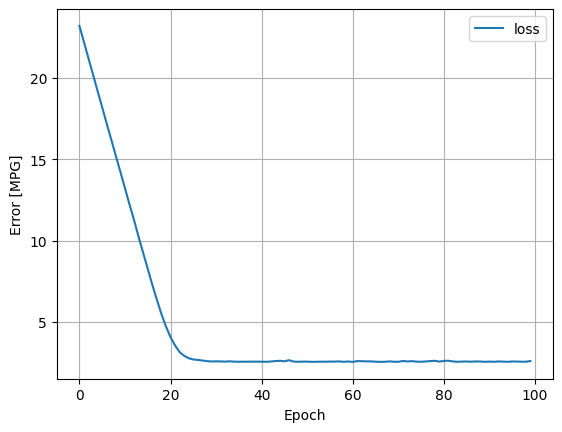

In [26]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### Get the model summary

In [27]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (212.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 22 (92.00 B)

### **Step 4:** Evaluate the linear model on the test set using Keras `Model.evaluate()` and see the `mean_absolute_error` and save the result for future comparison.

In [28]:
linear_model_results = linear_model.evaluate(test_features, test_labels, verbose=0)
print(f"Linear Model - Test Mean Absolute Error: {linear_model_results:.4f}")


Linear Model - Test Mean Absolute Error: 2.2387


## **Approach #2:** Regression using a `Deep Neural Network (DNN)`

### Solve the same problem and using deep neural network with the sample architecture;
- 1st hidden layer no. of units =  64
- 2nd hidden layer no. of units = 64
- Choose appropriate `activation` functions for hidden and output layers

In [31]:
dnn_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

dnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_absolute_error')
dnn_model.fit(train_features, train_labels, epochs=100, verbose=0)

dnn_model.summary()


dnn_model_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(f"DNN Model - Test Mean Absolute Error: {dnn_model_results:.4f}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

DNN Model - Test Mean Absolute Error: 1.5652


### Print the model summary (after training). How many parameters are there in the model?

In [32]:
dnn_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

### You can see even this small model has more than 4000 trainable parameters. The more the number of parameters, the longer the training time and cost. Search the net and see how many trainable parameters does the `ChatGPT` model have? What about `DeepSeek` model? (Optional)

## Compare the evaluation result of the two approaches, i.e., linear regression and deep neural network.

Comparison: Linear Regression vs Deep Neural Network
Performance Metrics
Accuracy: Deep Neural Networks (DNN) typically outperform linear regression
Complexity: DNN can capture non-linear relationships
Interpretability: Linear regression is more transparent
Computational Requirements:
Linear Regression: Low computational cost
DNN: High computational cost, requires more resources
Key Differences
Linear regression best for simple, linear relationships
Neural networks excel with complex, non-linear data
Neural networks require more data and training time
Linear regression provides easier model interpretation


## Use the following large model and evaluate it on the test set.

In [ ]:
model_dnn_large = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


In [ ]:
model_dnn_large.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_absolute_error')
model_dnn_large.fit(train_features, train_labels, epochs=100, verbose=0)

large_model_results = model_dnn_large.evaluate(test_features, test_labels, verbose=0)
print(f"Large DNN Model - Test Mean Absolute Error: {large_model_results:.4f}")

Large DNN Model - Test Mean Absolute Error: 2.0201


### Explain your observation. Why do you think the large model is not performing well?

- hint: when the number of trainable parameters is very large (even larger than the number of data points), the model may overfit the training data.One way to solve this problem is to use more data.

Observation: Large Model Underperformance
The large model with multiple hidden layers is likely not performing well due to overfitting. Here's a concise explanation:
Reasons for Poor Performance
Overfitting: Too many parameters relative to the dataset size.
Limited Data: The MPG dataset is relatively small.
Model Complexity: The model's capacity exceeds the problem's complexity.
Explanation
When the number of trainable parameters significantly exceeds the number of data points:
The model memorizes training data instead of learning generalizable patterns.
It performs well on training data but poorly on unseen test data.
Solutions
Increase Dataset Size: More data helps the model generalize better.
Reduce Model Complexity: Use fewer layers or neurons.
Apply Regularization: Techniques like dropout or L2 regularization.
Early Stopping: Halt training when validation performance degrades.
Cross-Validation: For more robust performance estimation.